# WASSA2023

In [87]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Dependencies

In [1]:
repo_path = "https://raw.githubusercontent.com/HLT-Ghisolfi-Leuzzi-Testa/WASSA-2023/"
branch = "main"

In [2]:
!pip install transformers -q
!pip install accelerate -U -q
!pip install datasets -q
!pip install torch-summary -q
!pip install bertviz -q
!pip install NRCLex -q
!pip install textblob -q
!python -m textblob.download_corpora -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 28.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 87.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 51.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.6/157.6 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.7/135.7 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
utils_url = f"{repo_path}{branch}/utils.py"
evaluation_url = f"{repo_path}{branch}/evaluation.py"

import os
if os.path.exists("utils.py"):
  !rm "utils.py"
if os.path.exists("evaluation.py"):
  !rm "evaluation.py"

!wget {utils_url}
!wget {evaluation_url}

--2023-07-21 07:45:11--  https://raw.githubusercontent.com/HLT-Ghisolfi-Leuzzi-Testa/WASSA-2023/main/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 39272 (38K) [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]  38.35K  --.-KB/s    in 0.001s  

2023-07-21 07:45:12 (63.2 MB/s) - ‘utils.py’ saved [39272/39272]

--2023-07-21 07:45:12--  https://raw.githubusercontent.com/HLT-Ghisolfi-Leuzzi-Testa/WASSA-2023/main/evaluation.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10675 (10K) [text/pl

In [67]:
import sys
from typing import Optional, Union, Tuple
import json
import random
import string
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import torch
from torch import nn
from torch.utils.data import Dataset
from transformers import (
	TrainingArguments,
	Trainer,
	TrainerCallback,
	EarlyStoppingCallback,
	AutoTokenizer,
	BertModel,
	RobertaModel,
	BertForSequenceClassification,
	RobertaForSequenceClassification,
	AutoModelForSequenceClassification
	)
from transformers.modeling_outputs import SequenceClassifierOutput
from nrclex import NRCLex
import importlib
from utils import *
importlib.reload(sys.modules['utils'])

<module 'utils' from '/content/utils.py'>

In [5]:
# set CUDA if available
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("======= CUDA Available =======")
else:
    device = torch.device('cpu')
    print("======= CUDA NOT Available, run on CPU =======")

======= CUDA Available =======


## Set up

In [116]:
EMOTIONS_LEX = [
    'fear',
    'anger',
    'anticipation',
    'trust',
    'surprise',
    'positive',
    'negative',
    'sadness',
    'disgust',
    'joy',
]

EMOTIONS_TO_PREDICT = [
    'sadness',
    'neutral',
    'fear',
    'anger',
    'surprise',
    'joy',
    'hope',
    'disgust'
]

config = {}

In [124]:
#@title Task type
TASK = "EMO" #@param ["EMO", "EMP"]

In [125]:
#@title Number of labels
num_labels = 8 #@param {type:"integer"}
neutral_zero = False
if TASK == "EMO":
    if num_labels==7:
        neutral_zero = True
    else:
        num_labels = 8
config['num_labels'] = num_labels

In [126]:
#@title Model Class
model_id = 'GO_lexicon' #@param {type:"string"}
model_class_string = "RobertaPreTrainedModel" #@param ["BertPreTrainedModel", "RobertaPreTrainedModel"]
model_name = 'distilroberta-base' #@param ["bert-base", "roberta-base", "roberta-emotion", "distilroberta-emotion", "roberta-empathy", "roberta-go", "distilroberta-base"]

if model_class_string == "BertPreTrainedModel":
  model_class = BertForSequenceClassification
else:
  model_class = RobertaForSequenceClassification

config['model_id'] = model_id
config['model_class_string'] = model_class_string
config['model_name'] = model_name

In [127]:
#@title Global Features
emo_count_global = True #@param {type:"boolean"}

config['emo_count_global'] = emo_count_global


In [128]:
#@title Local Features
emo_count_local = False #@param {type:"boolean"}

config['emo_count_local'] = emo_count_local

In [129]:
#@title Prompt
emo_prompt = False #@param {type:"boolean"}
emo_sep = 'after SEP' #@param ["after SEP", "before SEP"]

config['emo_prompt'] = emo_prompt
config['sep'] = emo_sep

In [130]:
#@title Model configuration
train_batch_size = 8 #@param {type:"integer"}
val_batch_size = 8 #@param {type:"integer"}
learning_rate = 2e-5 #@param {type:"number"}
weight_decay = 0.08 #@param {type:"number"}
epochs = 30 #@param {type:"integer"}
patience = 5 #@param {type:"integer"}
dropout = 0.3 #@param {type:"number"}
weighted_loss = "None" #@param ["None", "normalized_inverse", "balanced"]

model_type ={
  'distilroberta-emotion':'j-hartmann/emotion-english-distilroberta-base',
  'roberta-emotion':'j-hartmann/emotion-english-roberta-large',
  'roberta-empathy': 'bdotloh/roberta-base-empathy',
  'bert-base': 'bert-base-cased',
  'roberta-base' : 'roberta-base',
  'roberta-go': 'SamLowe/roberta-base-go_emotions',
  'distilroberta-base' : 'distilroberta-base'
}

model_config = {
    'model_id': model_id,
    'tokenizer_name': model_type.get(model_name),
    'model_name': model_type.get(model_name),
    'train_batch_size': train_batch_size,
    'val_batch_size': val_batch_size,
    'learning_rate': learning_rate,
    'weight_decay': weight_decay,
    'epochs': epochs,
    'seed': 42,
    'patience': patience,
    'early_stopping_threshold': 0,
    'weighted_loss': weighted_loss,
    'dropout' : dropout
}

config.update(model_config)

In [131]:
path_tosave = f"{TASK}_{model_config['model_id']}"
!mkdir $path_tosave

write_dict_to_json(config, f"{path_tosave}/config.json")

print("\nCONFIGURATION")
for k,v in config.items():
  print(f"{k}: {v}")

mkdir: cannot create directory ‘EMO_GO_lexicon’: File exists

CONFIGURATION
model_id: GO_lexicon
model_class_string: RobertaPreTrainedModel
model_name: distilroberta-base
tokenizer_name: distilroberta-base
train_batch_size: 8
val_batch_size: 8
learning_rate: 2e-05
weight_decay: 0.08
epochs: 30
seed: 42
patience: 5
early_stopping_threshold: 0
weighted_loss: None
dropout: 0.3
num_labels: 8
emo_count_global: True
emo_count_local: False
emo_prompt: False
sep: after SEP


## Dataset

### WASSA dataset

In [97]:
class GODataset(Dataset):

    def __init__(
        self,
        tokenizer,
        essay,
        targets,
        max_len = None,
        emo_lexicon = False
        ):
        self.tokenizer = tokenizer
        self.essay = essay
        self.targets = targets
        self.max_len = max_len
        self.emo_lexicon = emo_lexicon

    def __len__(self):
        return len(self.essay)

    def __getitem__(self, index):
        essay = str(self.essay[index])

        inputs = self.tokenizer.encode_plus(
            text=essay,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
            return_token_type_ids=True
        )

        item = {
          'input_ids': inputs['input_ids'].flatten(),
          'attention_mask': inputs['attention_mask'].flatten(),
          'token_type_ids': inputs["token_type_ids"].flatten()
        }

        if self.targets is not None:
          item['labels'] = torch.FloatTensor(self.targets[index])

        if self.emo_lexicon:
          emotions = NRCLex(essay).affect_frequencies
          emotions.pop('anticip')
          if 'anticipation' not in list(emotions.keys()):
            emotions['anticipation'] = 0.0
          item['emo_lexicon'] = torch.FloatTensor(list(emotions.values()))


        return item

Read dataframes

In [98]:
GO_DATA = f"{repo_path}{branch}/datasets/GO-emotions/goemotions.csv"

go_df = pd.read_csv(GO_DATA)

Encode targets

In [99]:
label_encoder = EmotionsLabelEncoder()
label_encoder.fit(go_df.emotion)
y = label_encoder.encode(go_df.emotion)

Data splits

In [100]:
text_train, text_test, y_train, y_test = train_test_split(np.array(go_df.essay), y,
                                                          stratify=y,
                                                          test_size=0.15,
                                                          random_state=3)
text_train, text_val, y_train, y_val = train_test_split(text_train, y_train,
                                                          stratify=y_train,
                                                          test_size=0.15,
                                                          random_state=1)

## Model

### Custom model

In [102]:
class ClassificationHead(nn.Module):
    """Head for sentence-level classification tasks."""

    def __init__(self, config, num_extra_dims):
        super().__init__()
        total_dims = config.hidden_size+num_extra_dims
        self.dense = nn.Linear(total_dims, total_dims)
        classifier_dropout = (
            config.classifier_dropout if config.classifier_dropout is not None else config.hidden_dropout_prob
        )
        self.dropout = nn.Dropout(classifier_dropout)
        self.out_proj = nn.Linear(total_dims, config.num_labels)

    def forward(self, features, **kwargs):
        x = self.dropout(features)
        x = self.dense(x)
        x = torch.tanh(x)
        x = self.dropout(x)
        x = self.out_proj(x)
        return x

class CustomSequenceClassification(RobertaForSequenceClassification):

    def __init__(self, config, num_extra_dims):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.config = config

        # might need to rename this depending on the model
        self.roberta =  RobertaModel(config)
        self.classifier = ClassificationHead(config, num_extra_dims)

        # Initialize weights and apply final processing
        self.post_init()


    def forward(
        self,
        input_ids: Optional[torch.LongTensor] = None,
        attention_mask: Optional[torch.FloatTensor] = None,
        emo_lexicon: Optional[torch.FloatTensor] = None,
        token_type_ids: Optional[torch.LongTensor] = None,
        position_ids: Optional[torch.LongTensor] = None,
        head_mask: Optional[torch.FloatTensor] = None,
        inputs_embeds: Optional[torch.FloatTensor] = None,
        labels: Optional[torch.LongTensor] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[Tuple, SequenceClassifierOutput]:

        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        outputs = self.roberta(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        # sequence_output will be (batch_size, seq_length, hidden_size)
        sequence_output = outputs[0]

        # additional data should be (batch_size, num_extra_dims)
        cls_embedding = sequence_output[:, 0, :]

        output = torch.cat((cls_embedding, emo_lexicon), dim=-1)

        logits = self.classifier(output)

        loss = None
        if labels is not None:
            if self.config.problem_type is None:
                if self.num_labels == 1:
                    self.config.problem_type = "regression"
                elif self.num_labels > 1 and (labels.dtype == torch.long or labels.dtype == torch.int):
                    self.config.problem_type = "single_label_classification"
                else:
                    self.config.problem_type = "multi_label_classification"

            if self.config.problem_type == "regression":
                loss_fct = nn.MSELoss()
                if self.num_labels == 1:
                    loss = loss_fct(logits.squeeze(), labels.squeeze())
                else:
                    loss = loss_fct(logits, labels)
            elif self.config.problem_type == "single_label_classification":
                loss_fct = nn.CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            elif self.config.problem_type == "multi_label_classification":
                loss_fct = nn.BCEWithLogitsLoss()
                loss = loss_fct(logits, labels)

        if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

In [103]:
tokenizer = AutoTokenizer.from_pretrained(config.get('tokenizer_name'), truncation=True)
tokenizer

RobertaTokenizerFast(name_or_path='distilroberta-base', vocab_size=50265, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False)}, clean_up_tokenization_spaces=True)

In [132]:
model = CustomSequenceClassification.from_pretrained(config.get('model_name'),
                                                          num_extra_dims = len(EMOTIONS_LEX),
                                                          problem_type = "multi_label_classification",
                                                          num_labels = config.get('num_labels'),
                                                          classifier_dropout = config.get('dropout'),
                                                          ignore_mismatched_sizes=True )

Some weights of CustomSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [68]:
model = AutoModelForSequenceClassification.from_pretrained(config.get('model_name'),
                                                          problem_type = "multi_label_classification",
                                                          num_labels = config.get('num_labels'),
                                                          classifier_dropout = config.get('dropout'),
                                                          ignore_mismatched_sizes=True )
model

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-5): 6 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (

## Training

Prepare datasets

In [133]:
train_set = GODataset(tokenizer=tokenizer,
                    essay = text_train,
                    targets = y_train,
                      emo_lexicon = True
                )

val_set = GODataset(tokenizer=tokenizer,
                    essay = text_val,
                    targets = y_val,
                    emo_lexicon = True
                )
test_set = GODataset(tokenizer=tokenizer,
                    essay = text_test,
                    targets = y_test,
                    emo_lexicon = True
                )

Set up training

In [134]:
train_arguments = TrainingArguments(
    output_dir=f"./{config.get('model_name')}",
    per_device_train_batch_size = config.get('train_batch_size'),
    per_device_eval_batch_size = config.get('val_batch_size'),
    num_train_epochs = config.get('epochs'),
    evaluation_strategy = "steps",
    save_strategy = "steps",
    logging_strategy = "steps",
    logging_steps = 150,
    eval_steps = 150,
    save_steps = 150,
    learning_rate=config.get('learning_rate'),
    weight_decay=config.get('weight_decay'),
    load_best_model_at_end=True,
    metric_for_best_model = "eval_macro_f1",
    seed=config.get('seed'),
)

In [135]:
trainer = Trainer(
    model=model,
    args=train_arguments,
    train_dataset=train_set,
    eval_dataset=val_set,
    tokenizer=tokenizer,
    compute_metrics=compute_EMO_metrics_trainer
)

Callbacks

In [136]:
class TrainerLoggingCallback(TrainerCallback):
    def __init__(self, log_path):
        self.log_path = log_path

    def on_log(self, args, state, control, logs=None, **kwargs):
        _ = logs.pop("total_flos", None)
        if state.is_local_process_zero: # whether this process is the main one in a distributed setting
            with open(self.log_path, "a") as f:
                f.write(json.dumps(logs) + "\n")

trainer.add_callback(EarlyStoppingCallback(
    early_stopping_patience = config.get('patience'),
    early_stopping_threshold = config.get('early_stopping_threshold')))

trainer.add_callback(TrainerLoggingCallback(config.get('model_id')+"_log.json"))

Start training

In [137]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Macro F1,Micro F1,Micro Jaccard,Macro Precision,Macro Recall,Micro Precision,Micro Recall,Sklearn Accuracy,Roc Auc Micro
150,0.330200,0.290732,0.089859,0.561129,0.389978,0.070141,0.125000,0.561129,0.561129,0.561129,0.749216
300,0.277200,0.258225,0.139497,0.579937,0.408389,0.185839,0.163335,0.579937,0.579937,0.579937,0.759964
450,0.263400,0.240923,0.217929,0.597179,0.425698,0.310279,0.213793,0.597179,0.597179,0.597179,0.769816
600,0.236000,0.230410,0.322789,0.623824,0.453303,0.386917,0.318988,0.623824,0.623824,0.623824,0.785043
750,0.230700,0.240770,0.347378,0.601881,0.430493,0.666242,0.348368,0.601881,0.601881,0.601881,0.772503
900,0.217200,0.224060,0.391856,0.647335,0.478563,0.478576,0.388442,0.647335,0.647335,0.647335,0.798477
1050,0.189900,0.228887,0.454027,0.666144,0.499412,0.598568,0.406372,0.666144,0.666144,0.666144,0.809225
1200,0.182000,0.223930,0.450383,0.650470,0.481998,0.546206,0.429661,0.650470,0.650470,0.650470,0.800269
1350,0.195900,0.224648,0.467193,0.652038,0.483721,0.539452,0.431730,0.652038,0.652038,0.652038,0.801164
1500,0.170600,0.231870,0.457628,0.652038,0.483721,0.547828,0.425304,0.652038,0.652038,0.652038,0.801164


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

TrainOutput(global_step=3000, training_loss=0.17318311373392742, metrics={'train_runtime': 1503.954, 'train_samples_per_second': 72.05, 'train_steps_per_second': 9.016, 'train_loss': 0.17318311373392742, 'epoch': 6.64})

In [138]:
metric_for_val = "eval_macro_f1"
# Access the training logs
train_logs = trainer.state.log_history

metrics = [list(log.keys())[:-5] for log in train_logs if log.get('eval_loss') is not None][0]

train_loss_values = []
eval_loss_values = []
eval_metrics_values = []
for _ in metrics:
  eval_metrics_values.append([])
train_epochs = []
eval_epochs = []

best_metric = 0
best_train_loss = float('inf')
best_eval_loss = float('inf')

for log in train_logs:

  if log.get(metric_for_val) is not None:

    if log.get(metric_for_val) > best_metric:
      best_metric = log.get(metric_for_val)
      best_steps = log.get('step')
      best_epoch_metric = log.get('epoch')
    if log.get('eval_loss') < best_eval_loss:
      best_eval_loss = log.get('eval_loss')
      best_epoch_eval_loss = log.get('epoch')

    for i, metric in enumerate(metrics):
      eval_metrics_values[i].append(log.get(metric))

    eval_loss_values.append(log.get('eval_loss'))
    eval_epochs.append(log.get('epoch'))

  if log.get('loss') is not None:
    if log.get('loss') < best_train_loss:
      best_train_loss = log.get('loss')

    train_loss_values.append(log.get('loss'))
    train_epochs.append(log.get('epoch'))


Plot losses

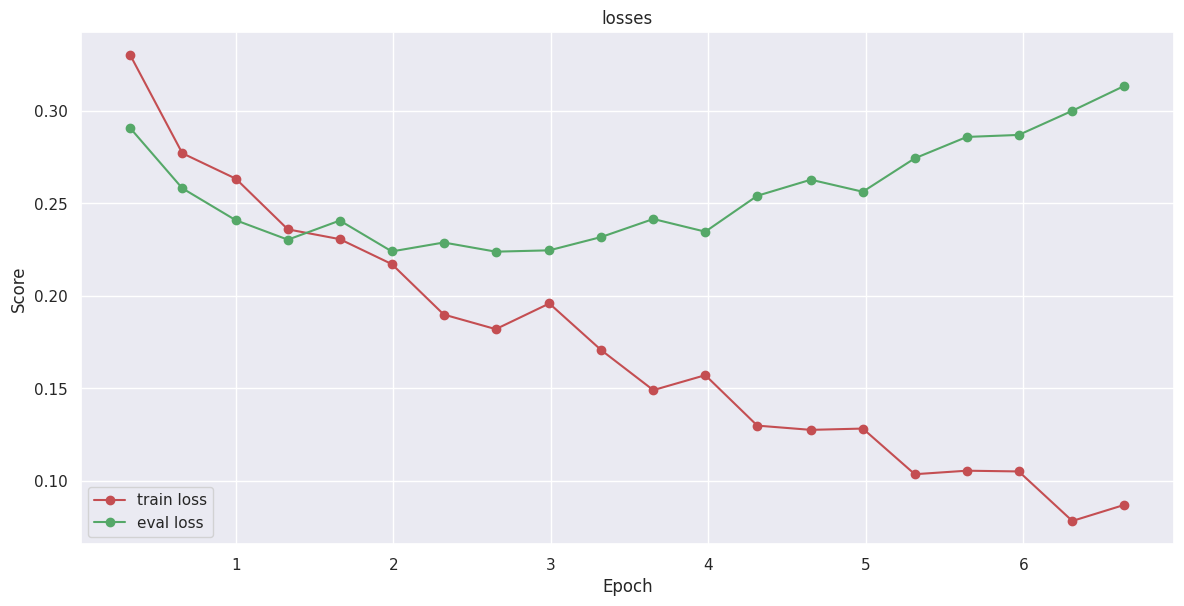

In [139]:
fig_name = "losses"
plot_metric_curve(
    values = [train_loss_values, eval_loss_values],
    epochs = [train_epochs, eval_epochs],
    metrics = ["train loss", "eval loss"],
    title = fig_name,
    path = f"{path_tosave}/{fig_name}.png")

Plot metrics

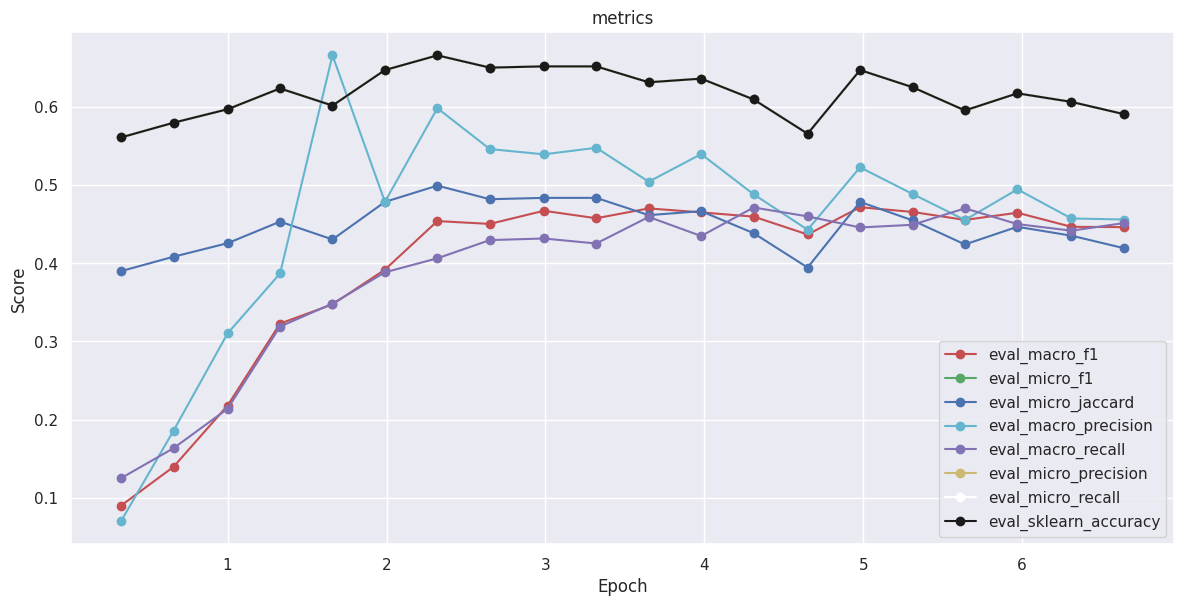

In [140]:
fig_name = "metrics"
plot_metric_curve(
    values = eval_metrics_values[1:],
    epochs = [eval_epochs for _ in eval_metrics_values[1:]],
    metrics = metrics[1:],
    title = fig_name,
    path = f"{path_tosave}/{fig_name}.png")

## Evaluation

In [141]:
def predict_emotions(results, neutral_zero):

  binarized_predictions = np.where(results >= 0.5, 1, 0)

  if not neutral_zero:
    for i, bin_pred in enumerate(binarized_predictions):
      if np.all(bin_pred==0):
        binarized_predictions[i][np.argmax(results[i])] = 1

  predicted_emotions = label_encoder.decode(binarized_predictions)
  return predicted_emotions


In [142]:
print(trainer.state.best_model_checkpoint)

outs = trainer.predict(test_set)

./distilroberta-base/checkpoint-2250


In [143]:
golds = label_encoder.decode(outs.label_ids)
predictions = predict_emotions(outs.predictions, False)

In [144]:
path_predictions = f"{path_tosave}/dev_predictions_{TASK}.tsv"
path_metrics = f"{path_tosave}/dev_metrics_{TASK}.json"

scores = {
    'train_loss': float(best_train_loss),
    'eval_loss': float(best_eval_loss)
}

write_predictions(predictions, path_predictions)
challenge_metrics = compute_metrics(golds=golds, predictions=predictions, task=TASK)
scores.update(challenge_metrics)
scores['best_metric'] = float(best_metric)
scores['best_epoch_metric'] = float(best_epoch_metric)
scores['best_epoch_eval_loss'] =  float(best_epoch_eval_loss)

write_dict_to_json(scores, path_metrics)

scores

{'train_loss': 0.0782,
 'eval_loss': 0.22392965853214264,
 'macro_f1': 0.4355,
 'micro_f1': 0.624,
 'micro_jaccard': 0.4535,
 'macro_precision': 0.4878,
 'macro_recall': 0.4079,
 'micro_precision': 0.624,
 'micro_recall': 0.624,
 'best_metric': 0.47176213559770763,
 'best_epoch_metric': 4.98,
 'best_epoch_eval_loss': 2.65}

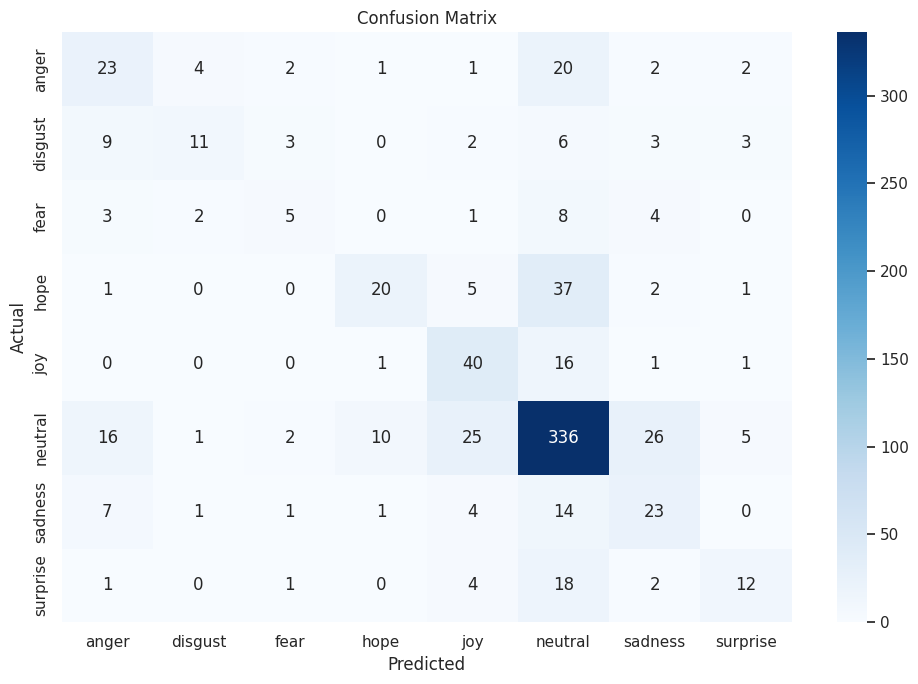

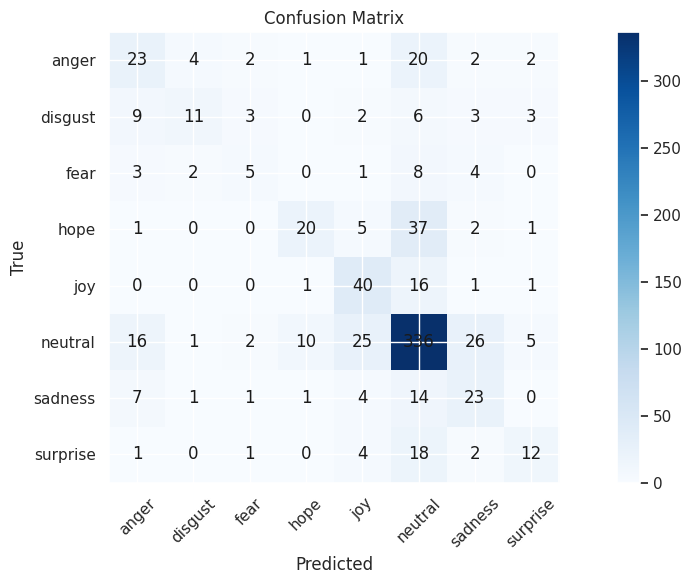

In [83]:
fig_name = "confusion_matrix"
plot_confusion_matrix(golds=golds,
                      predictions=predictions,
                      path= f"{path_tosave}/{fig_name}.png"
                      )
print("\n")
fig_name = "confusion_matrix_per_emotions"
plot_confusion_matrix_per_emotions(gold_emotions = golds,
                                    predicted_emotions = predictions,
                                    path= f"{path_tosave}/{fig_name}.png"
                                    )

In [149]:
def load_checkpoint_and_compute_metrics(checkpoint_path, test_set):

  model = CustomSequenceClassification.from_pretrained(checkpoint_path,
                                                          num_extra_dims = len(EMOTIONS_LEX),
                                                          problem_type = "multi_label_classification",
                                                          num_labels = config.get('num_labels'),
                                                          classifier_dropout = config.get('dropout'),
                                                          ignore_mismatched_sizes=True )
  trainer = Trainer(model=model)
  # Perform prediction using the loaded checkpoint
  outs = trainer.predict(test_set)

  golds = label_encoder.decode(outs.label_ids)
  predictions = predict_emotions(outs.predictions, golds)


  path_predictions = f"{path_tosave}/predictions_best_metric.tsv"
  path_metrics = f"{path_tosave}/dev_metrics_best_metric.json"

  #write_predictions(predictions, path_predictions)
  challenge_metrics = compute_metrics(golds=golds, predictions=predictions, task=TASK)

  #write_dict_to_json(challenge_metrics, path_metrics)

  print(challenge_metrics)


In [150]:
best_metric_path = f"/content/{config.get('model_name')}/checkpoint-1650"
print(best_metric_path)
load_checkpoint_and_compute_metrics(best_metric_path, test_set)

/content/distilroberta-base/checkpoint-1650


{'macro_f1': 0.385, 'micro_f1': 0.6026, 'micro_jaccard': 0.4312, 'macro_precision': 0.6123, 'macro_recall': 0.3279, 'micro_precision': 0.7114, 'micro_recall': 0.5227}


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:895: UserWarning: unknown class(es) [''] will be ignored
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Save on Google Drive

In [151]:
# move the best checkpoint in the folder with model id
best_model_path = trainer.state.best_model_checkpoint

!mv $best_model_path /content/$path_tosave

In [154]:
# move the results to personal drive
!mv /content/EMO_GO_lexicon /content/drive/MyDrive/hlt

In [ ]:
for i, row in go_df.iterrows():
  print(row.emotion)
  print(NRCLex(row.essay).affect_frequencies)
  print("\n")